<h1><center><b>Autoencoder on MNIST using Keras</b><center></h1>    
<center><b>LY Timothée - PERSONNAZ Louis</b></center>

In [117]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Importing TensorFlow and Keras

In [118]:
import tensorflow as tf
import tensorflow.keras as keras
from keras.datasets import mnist
from tensorflow.keras.utils import plot_model, to_categorical, normalize
from tensorflow.keras.losses import MeanSquaredError, MSE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import SGD, Adam

print(f"Using tensorflow version {tf.__version__}")
print(f"Using keras version {keras.__version__}")

Using tensorflow version 2.8.0
Using keras version 2.8.0


In [119]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Loading and preparing the MNIST dataset

Load the MNIST dataset via keras.datasets. Again, turn train and test labels into one-hot encoding, and reshape and normalize data as in the first exercise. 

In [120]:
# The MNSIT dataset is ready to be imported from Keras into RAM
# Warning: you cannot do that for larger databases (e.g. ImageNet)
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [121]:
print(f"### shapes ###\nX_train: {X_train.shape}\ny_train: {y_train.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}")

### shapes ###
X_train: (60000, 28, 28)
y_train: (60000,)
X_test: (10000, 28, 28)
y_test: (10000,)


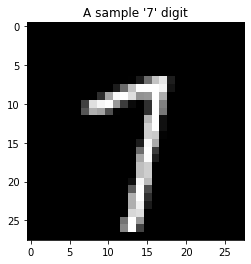

In [122]:
dig = 42
_ = plt.imshow(X_train[dig], cmap='gray')
_ = plt.title(f"A sample '{y_train[42]}' digit")

In [123]:
# Do you remember about one-hot encoding ?
y_train = to_categorical(y_train, num_classes=np.unique(y_train).size)
y_test = to_categorical(y_test, num_classes=np.unique(y_test).size)

In [124]:
train_images = X_train
test_images = X_test

In [125]:
# Reshape to proper images with 1 color channel according to backend scheme
img_rows, img_cols = train_images.shape[1], train_images.shape[2]
train_images = train_images.reshape(-1, img_rows*img_cols)
test_images = test_images.reshape(-1, img_rows*img_cols)

# Cast pixels from uint8 to float32
train_images = train_images.astype(np.float32)
test_images = test_images.astype(np.float32)

# Now let us normalize the images so that they have zero mean and standard deviation
# Hint: are real testing data statistics known at training time ?
"""
scaler = StandardScaler()
train_images = scaler.fit_transform(train_images)
test_images = scaler.transform(test_images)
"""
#train_images = normalize(train_images)
#test_images = normalize(test_images)
train_images = train_images / 255
test_images = test_images / 255

## Autoencoder and PCA

First, we will try to connect the representation produced by Principal Component Analysis with what is learnt by a simple, linear, autoencoder. We will use the ```scikit-learn``` implementation of the ```PCA``` to obtain the two first components (hint: use the attribute ```.components_```), and visualize them:

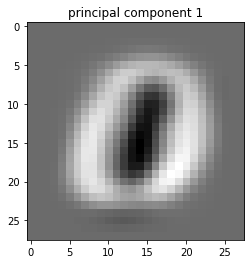

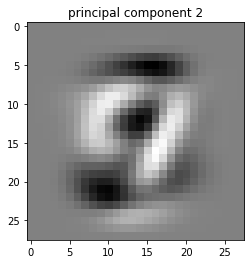

In [126]:
# Let's find the first 2 PCA components
num_components = 2
pca = PCA(n_components=num_components)
pca.fit(train_images)

# Reshape so they resemble images and we can print them
train_images = train_images.reshape(-1, img_rows, img_cols)
test_images = test_images.reshape(-1, img_rows, img_cols)

# Show the reshaped principal components
plt.imshow(pca.components_[0].reshape(img_rows, img_cols), cmap='gray')
plt.title("principal component 1")
plt.show()

plt.imshow(pca.components_[1].reshape(img_rows, img_cols), cmap='gray')
plt.title("principal component 2")
plt.show()

In [127]:
# Print the variance explained by those components
pca.explained_variance_ratio_

array([0.0970472 , 0.07095961], dtype=float32)

**Comment on the visualization in relation to the variance explained by only keeping the two principal components.**

In [128]:
print(f"The total explained variance is around {100*np.sum(pca.explained_variance_ratio_):.1f}%")

The total explained variance is around 16.8%


Now, we will use Keras to implement the autoencoder. You can take a look at this [cheatsheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Keras_Cheat_Sheet_Python.pdf) for some basic commands to use keras.

In this first case, we implement a **simple linear autoencoder**. Build it in order to have the same capacity as the PCA decomposition (2 hidden dimensions!) we made just above. 

In [129]:
# Input layer
input_layer = Input(shape=(img_cols*img_rows,), name="input")

# Encoding layer
latent_view = Dense(num_components, name="latent")

# Decoding layer
output_layer = Dense(img_rows*img_cols, name="output")

# Define Sequential model with 3 layers
autoencoder = keras.Sequential([input_layer, latent_view, output_layer], name='autoencoder')

In [130]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 latent (Dense)              (None, 2)                 1570      
                                                                 
 output (Dense)              (None, 784)               2352      
                                                                 
Total params: 3,922
Trainable params: 3,922
Non-trainable params: 0
_________________________________________________________________


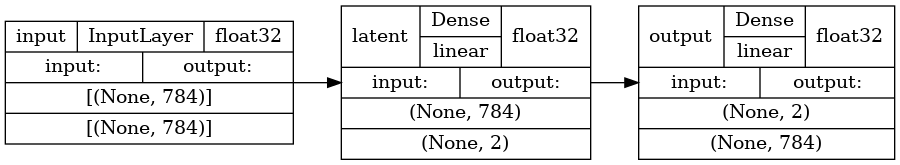

In [131]:
plot_model(autoencoder, rankdir='LR', show_shapes=True, show_dtype=True, show_layer_activations=True)

What loss shoud we use? Choose the usual one and import it directly from Keras. You can use a simple ```SGD``` optimizer, and then compile the model; finally, train it to rebuild images from the original examples.  

> We can use the Mean Squared Error as shown in the following.

In [132]:
autoencoder.compile(optimizer='adam', loss='mse')

In [133]:
# Reshape back
train_images = train_images.reshape(-1, img_rows*img_cols)
test_images = test_images.reshape(-1, img_rows*img_cols)

batch_size = 128
epochs = 10
# No noise here - we want to train a simple auto-encoder and compare visually with PCA
history = autoencoder.fit(train_images,
                          train_images,
                          epochs=epochs,
                          batch_size=batch_size,
                          verbose=1,
                          shuffle=True,
                          validation_data=(test_images, test_images))

Epoch 1/10
469/469 [==============================] - 2s 3ms/step - loss: 0.0643 - val_loss: 0.0580
Epoch 2/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0576 - val_loss: 0.0574
Epoch 3/10
469/469 [==============================] - 2s 3ms/step - loss: 0.0573 - val_loss: 0.0572
Epoch 4/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0571 - val_loss: 0.0570
Epoch 5/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0568 - val_loss: 0.0567
Epoch 6/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0566 - val_loss: 0.0564
Epoch 7/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0563 - val_loss: 0.0560
Epoch 8/10
469/469 [==============================] - 2s 3ms/step - loss: 0.0562 - val_loss: 0.0558
Epoch 9/10
469/469 [==============================] - 2s 3ms/step - loss: 0.0561 - val_loss: 0.0558
Epoch 10/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0560 - val_loss: 0.0557

Assuming that the name of your layer (obtained through the command ```ae_model.summary()```) is ```'layer'```, here is the way to obtain the weights. Visualize the weights of the encoder and compare them to the two components obtained through the PCA.

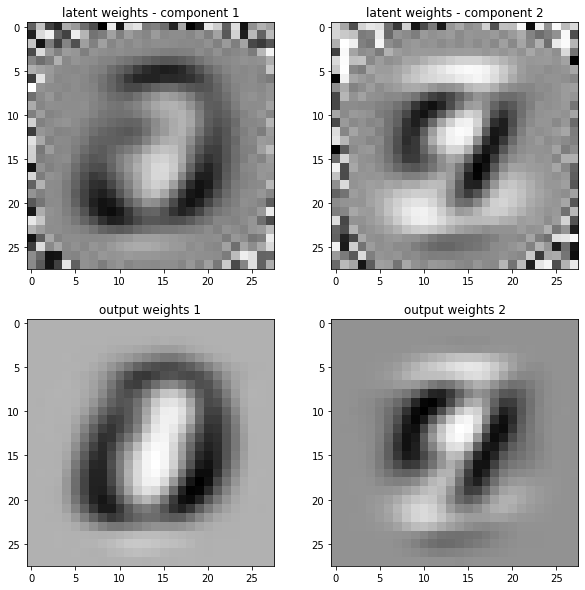

In [134]:
# Show the two dimensions of the encoder, in a similar manner to the principal components
# (after reshaping them as images !)

latent_weights, latent_bias = autoencoder.get_layer('latent').get_weights()
output_weights, output_bias = autoencoder.get_layer('output').get_weights()

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0][0].imshow(latent_weights[:,0].reshape(img_rows, img_cols), cmap='Greys')
ax[0][0].set_title("latent weights - component 1")
ax[0][1].imshow(latent_weights[:,1].reshape(img_rows, img_cols), cmap='Greys')
ax[0][1].set_title("latent weights - component 2")
ax[1][0].imshow(output_weights[0,:].reshape(img_rows, img_cols), cmap='Greys')
ax[1][0].set_title("output weights 1")
ax[1][1].imshow(output_weights[1,:].reshape(img_rows, img_cols), cmap='Greys')
ax[1][1].set_title("output weights 2")

plt.show()

Now, visualize the images rebuilt by the network!

In [135]:
# Select a few images at random
idx = np.random.randint(0, len(test_images) - 5)

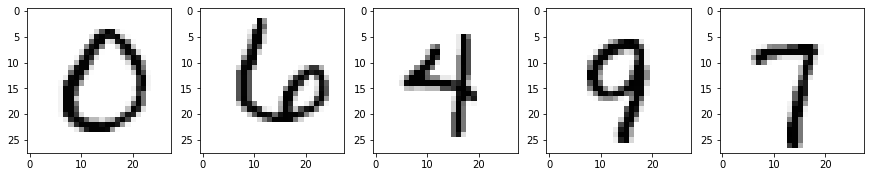

In [136]:
# Plot a few images from idx
f, ax = plt.subplots(1, 5, figsize=(15, 5))
for i, a in enumerate(range(idx, idx+5)):
    ax[i].imshow(test_images[a].reshape(img_rows, img_cols), cmap='Greys')

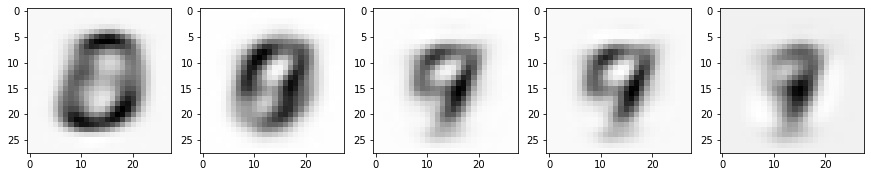

In [137]:
# Get the prediction from the model 
autoencoded_imgs = autoencoder.predict(test_images)

# And plot them 
f, ax = plt.subplots(1, 5, figsize=(15, 5))
for i, a in enumerate(range(idx, idx+5)):
    ax[i].imshow(autoencoded_imgs[a].reshape(img_rows, img_cols), cmap='Greys')

> Not that pretty, but it was foregone since we only used 2 dimensions!

Do the same (build a new model) with a latent dimension that is largely higher than 2. Compare the visualizations and the images that are rebuilt. 

In [138]:
num_components = 128

input_layer2 = Input(shape=(img_cols*img_rows,), name="input")
latent_view2 = Dense(num_components, name="latent")
output_layer2 = Dense(img_rows*img_cols, name="output")
autoencoder2 = keras.Sequential([input_layer2, latent_view2, output_layer2], name='autoencoder')
autoencoder2.compile(optimizer='adam', loss='mse')
history = autoencoder2.fit(train_images,
                           train_images,
                           epochs=epochs,
                           batch_size=batch_size,
                           verbose=1,
                           shuffle=True,
                           validation_data=(test_images, test_images))

Epoch 1/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0199 - val_loss: 0.0076
Epoch 2/10
469/469 [==============================] - 2s 3ms/step - loss: 0.0063 - val_loss: 0.0052
Epoch 3/10
469/469 [==============================] - 2s 3ms/step - loss: 0.0050 - val_loss: 0.0047
Epoch 4/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 5/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 8/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 9/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 10/10
469/469 [==============================] - 2s 3ms/step - loss: 0.0044 - val_loss: 0.0043

In [139]:
# Select a few images at random
idx = np.random.randint(0, len(test_images) - 5)

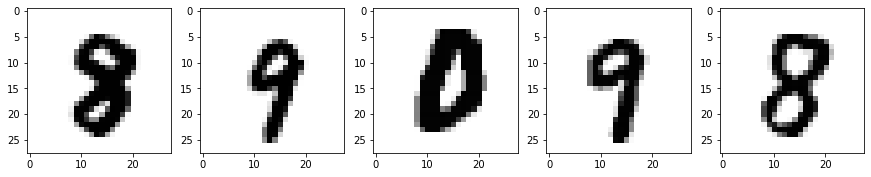

In [140]:
# Plot a few images from idx
f, ax = plt.subplots(1, 5, figsize=(15, 5))
for i, a in enumerate(range(idx, idx+5)):
    ax[i].imshow(test_images[a].reshape(img_rows, img_cols), cmap='Greys')

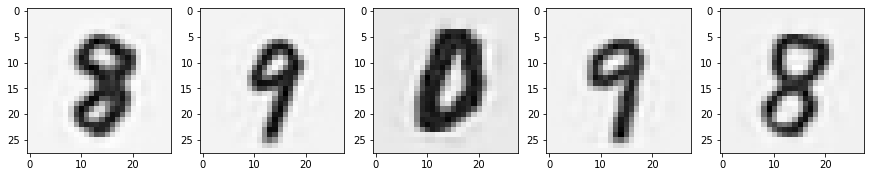

In [141]:
# Get the prediction from the model 
autoencoded_imgs2 = autoencoder2.predict(test_images)

# And plot them 
f, ax = plt.subplots(1, 5, figsize=(15, 5))
for i, a in enumerate(range(idx, idx+5)):
    ax[i].imshow(autoencoded_imgs2[a].reshape(img_rows, img_cols), cmap='Greys')

> This is indeed much better! But the autoencoder adds noise and blur in the images of the digits.

## Denoising auto-encoder 

Now, we can implement a **de-noising autoencoder**. The following function will transform an array of images by adding it random noise. Create a new autoencoder model, this time with **more layers** and **non-linear activations** (like the ReLU) and train it to rebuild the de-noised images. Display some testing images, with noise, and re-built. 

In [142]:
def noise(array, noise_factor=1):
    """
    Adds random noise to each image in the supplied array.
    """
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )
    return np.clip(noisy_array, 0, 1)

In [143]:
# Create a copy of the data with added noise
noisy_train_images = noise(train_images, noise_factor=0.3)
noisy_test_images = noise(test_images, noise_factor=0.3)

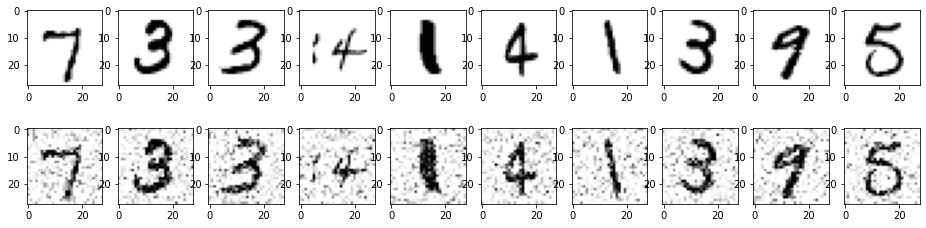

In [144]:
# Visualize some of the images with noise against the originals
idx = np.random.randint(0, noisy_test_images.shape[0], 10)
fig, ax = plt.subplots(2, 10, figsize=(16, 4))
for i, n in enumerate(idx):
    ax[0][i].imshow(test_images[n].reshape(img_rows, img_cols), cmap='Greys')
    ax[1][i].imshow(noisy_test_images[n].reshape(img_rows, img_cols), cmap='Greys')

In [145]:
# Build a new model with more layers and Relu activations
input_img = Input(shape=(img_cols*img_rows,))

encoded1  = Dense(128, activation='relu')(input_img)
encoded2  = Dense(64, activation='relu')(encoded1)
encoded3  = Dense(32, activation='relu')(encoded2)

decoded1  = Dense(64, activation='relu')(encoded3)
decoded2  = Dense(128, activation='relu')(decoded1)
decoded   = Dense(784, activation='sigmoid')(decoded2)

In [146]:
deep_autoencoder = Model(input_img, decoded, name="deep_autoencoder")
deep_autoencoder.compile(optimizer='adam', loss='mse')

In [147]:
deep_autoencoder.summary()

Model: "deep_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 784)]             0         
                                                                 
 dense_18 (Dense)            (None, 128)               100480    
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dense_20 (Dense)            (None, 32)                2080      
                                                                 
 dense_21 (Dense)            (None, 64)                2112      
                                                                 
 dense_22 (Dense)            (None, 128)               8320      
                                                                 
 dense_23 (Dense)            (None, 784)          

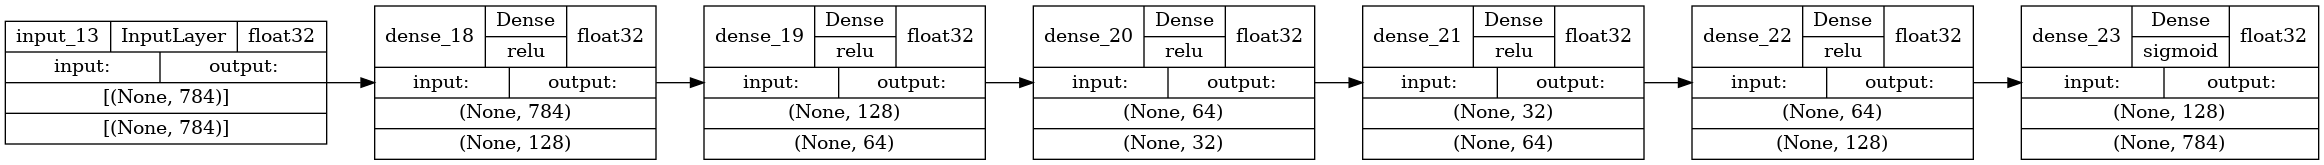

In [148]:
plot_model(deep_autoencoder, rankdir='LR', show_shapes=True, show_dtype=True, show_layer_activations=True)

In [149]:
# Compile it but here, use noisy data as inputs!
batch_size = 1024
epochs = 20
history = deep_autoencoder.fit(noisy_train_images,
                               train_images,
                               epochs=epochs,
                               batch_size=batch_size,
                               verbose=1,
                               shuffle=True,
                               validation_data=(noisy_test_images, test_images))

Epoch 1/20
59/59 [==============================] - 1s 9ms/step - loss: 0.0992 - val_loss: 0.0705
Epoch 2/20
59/59 [==============================] - 0s 8ms/step - loss: 0.0676 - val_loss: 0.0614
Epoch 3/20
59/59 [==============================] - 0s 8ms/step - loss: 0.0549 - val_loss: 0.0491
Epoch 4/20
59/59 [==============================] - 0s 7ms/step - loss: 0.0439 - val_loss: 0.0392
Epoch 5/20
59/59 [==============================] - 0s 8ms/step - loss: 0.0377 - val_loss: 0.0357
Epoch 6/20
59/59 [==============================] - 0s 8ms/step - loss: 0.0343 - val_loss: 0.0324
Epoch 7/20
59/59 [==============================] - 0s 8ms/step - loss: 0.0316 - val_loss: 0.0302
Epoch 8/20
59/59 [==============================] - 0s 7ms/step - loss: 0.0298 - val_loss: 0.0287
Epoch 9/20
59/59 [==============================] - 0s 7ms/step - loss: 0.0285 - val_loss: 0.0276
Epoch 10/20
59/59 [==============================] - 0s 7ms/step - loss: 0.0274 - val_loss: 0.0268
Epoch 11/20
59/59 [

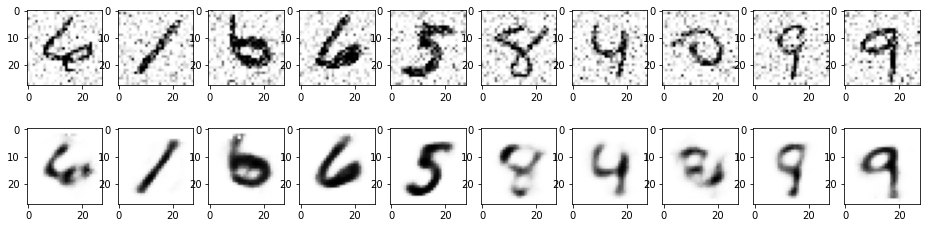

In [150]:
# Visualize the images rebuilt by the model!
deep_autoencoded_imgs = deep_autoencoder.predict(noisy_test_images)

idx = np.random.randint(0, noisy_test_images.shape[0], 10)
fig, ax = plt.subplots(2, 10, figsize=(16, 4))
for i, n in enumerate(idx):
    ax[0][i].imshow(noisy_test_images[n].reshape(img_rows, img_cols), cmap='Greys')
    ax[1][i].imshow(deep_autoencoded_imgs[n].reshape(img_rows, img_cols), cmap='Greys')

> This is quite satisfying, there is still some blur but the digits have been efficiently denoised.

> Let's now try with a Convolutional Neural Network, which should be more adapted to process images like the MNIST dataset.

In [151]:
input_img = Input(shape=(img_rows, img_cols, 1))

conv2D_1     = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
maxPooling2D = MaxPooling2D((2, 2), padding='same')(conv2D_1)
conv2D_2     = Conv2D(32, (3, 3), activation='relu', padding='same')(maxPooling2D)
encoded      = MaxPooling2D((2, 2), padding='same')(conv2D_2)

# At this point the representation is (7, 7, 32)

conv2D_3       = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
upSampling2D_1 = UpSampling2D((2, 2))(conv2D_3)
conv2D_4       = Conv2D(32, (3, 3), activation='relu', padding='same')(upSampling2D_1)
upSampling2D_2 = UpSampling2D((2, 2))(conv2D_4)
decoded        = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(upSampling2D_2)

conv_autoencoder = Model(input_img, decoded)
conv_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [152]:
conv_autoencoder.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_45 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 7, 7, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 7, 7, 32)          9248

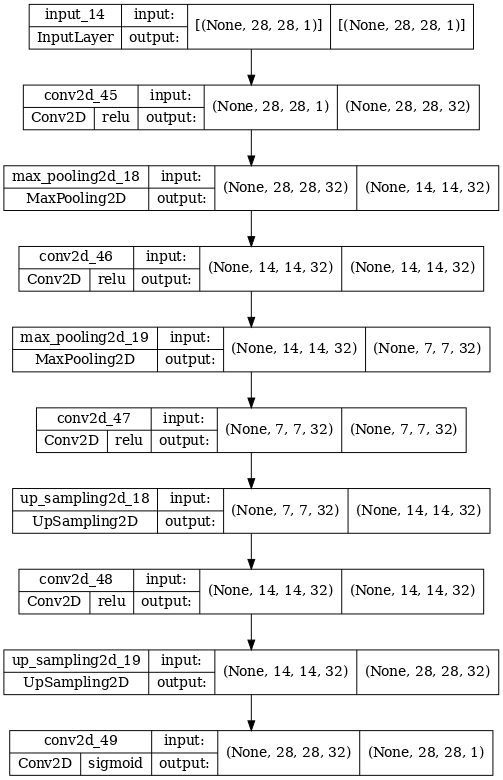

In [153]:
plot_model(conv_autoencoder, rankdir='TB', dpi=70, show_shapes=True, show_layer_activations=True)

In [154]:
conv_noisy_train_images = noisy_train_images.reshape(-1, img_rows, img_cols, 1)
conv_train_images = train_images.reshape(-1, img_rows, img_cols, 1)
conv_noisy_test_images = noisy_test_images.reshape(-1, img_rows, img_cols, 1)
conv_test_images = test_images.reshape(-1, img_rows, img_cols, 1)

batch_size = 1024
epochs = 15
history = conv_autoencoder.fit(conv_noisy_train_images,
                               conv_train_images,
                               epochs=epochs,
                               batch_size=batch_size,
                               verbose=1,
                               shuffle=True,
                               validation_data=(conv_noisy_test_images, conv_test_images))

Epoch 1/15
59/59 [==============================] - 1s 19ms/step - loss: 0.4001 - val_loss: 0.2099
Epoch 2/15
59/59 [==============================] - 1s 16ms/step - loss: 0.1632 - val_loss: 0.1293
Epoch 3/15
59/59 [==============================] - 1s 16ms/step - loss: 0.1185 - val_loss: 0.1084
Epoch 4/15
59/59 [==============================] - 1s 16ms/step - loss: 0.1055 - val_loss: 0.1018
Epoch 5/15
59/59 [==============================] - 1s 16ms/step - loss: 0.1000 - val_loss: 0.0971
Epoch 6/15
59/59 [==============================] - 1s 16ms/step - loss: 0.0969 - val_loss: 0.0944
Epoch 7/15
59/59 [==============================] - 1s 18ms/step - loss: 0.0945 - val_loss: 0.0929
Epoch 8/15
59/59 [==============================] - 1s 17ms/step - loss: 0.0929 - val_loss: 0.0915
Epoch 9/15
59/59 [==============================] - 1s 24ms/step - loss: 0.0916 - val_loss: 0.0900
Epoch 10/15
59/59 [==============================] - 1s 17ms/step - loss: 0.0907 - val_loss: 0.0896
Epoch 11/

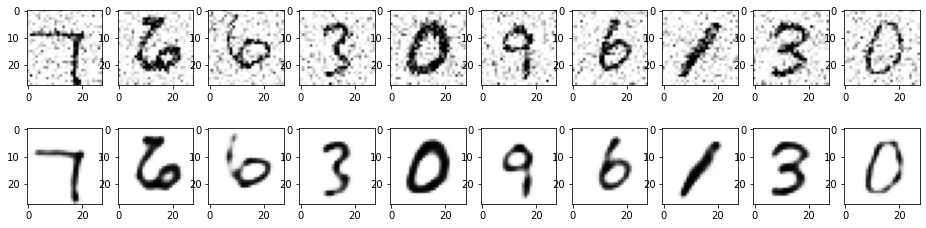

In [155]:
# Visualize the images rebuilt by the model!
conv_autoencoded_imgs = conv_autoencoder.predict(conv_noisy_test_images)

idx = np.random.randint(0, noisy_test_images.shape[0], 10)
fig, ax = plt.subplots(2, 10, figsize=(16, 4))
for i, n in enumerate(idx):
    ax[0][i].imshow(noisy_test_images[n].reshape(img_rows, img_cols), cmap='Greys')
    ax[1][i].imshow(conv_autoencoded_imgs[n].reshape(img_rows, img_cols), cmap='Greys')

> This is arguably a little better than the autoencoder's result above.

**Assuming that we normalize the images to be in the 0-1 range, what other loss function could we use ?**

> We can use the binary crossentropy loss (as done with the CNN), the Kullback-Leibler divergence, the Poisson loss.